# Polynomial Regression

We will carry out a polynomial regression next. The PolynomialFeature function allows us to transform our training data by adding the square (second degree polynomial) of each feature as well as the product of two features to our input features. Subsequently, we can carry out a linear regression on the transformed features to obtain a second degree polynomial regression model.

In [2]:
# code from previous notebooks of this section
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
import numpy as np

hb_data = pd.read_csv('HB_data.csv')
train_set, test_set = train_test_split(hb_data, test_size=0.2, random_state=42)

y_train = train_set['energy']
X_train = train_set.drop(['energy'], axis=1)

cat_pipeline = make_pipeline(OneHotEncoder())
# end code from previous notebooks of this section

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

num_pipeline = make_pipeline(PolynomialFeatures(degree=2, include_bias=True),StandardScaler())

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_polyr = make_pipeline(preprocessing, LinearRegression())

scores = -cross_val_score(model_polyr, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)

print(f"Root mean square error of each validation in kJ/mol:\n{scores}\n")
print("This is an average root mean square error of %0.2f kJ/mol with a standard deviation of %0.2f kJ/mol\n" % (scores.mean(), scores.std()))

Root mean square error of each validation in kJ/mol:
[5.08523546 5.38320832 4.06508922 4.16875129 4.19829657]

This is an average root mean square error of 4.58 kJ/mol with a standard deviation of 0.54 kJ/mol



We have already improved our fit compared to the linear regression model. We can test different degrees of polynomials with the code above. However, there is a more elegant way to train machine learning models with different hyperparameters and identify the best model. One option is a grid search which will carry out a cross-validation for all combinations of provided hyperparameters. We will train solely polynomials up to the 5th degree. Please note, the degree $d$ in combination with an array of $n$ input features will be transformed into an array containing $\frac{(n + d)!}{d!n!}$ input features. Thus, the 5th degree polynomial of our example has already 330 input features for the numerical inputs and 9 features representing the element types.

At first, we must get the correct name of the hyperparameter for our grid search code. This can be done by following line: 

In [3]:
model_polyr.get_params().keys()

dict_keys(['memory', 'steps', 'transform_input', 'verbose', 'columntransformer', 'linearregression', 'columntransformer__force_int_remainder_cols', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__verbose_feature_names_out', 'columntransformer__num', 'columntransformer__cat', 'columntransformer__num__memory', 'columntransformer__num__steps', 'columntransformer__num__transform_input', 'columntransformer__num__verbose', 'columntransformer__num__polynomialfeatures', 'columntransformer__num__standardscaler', 'columntransformer__num__polynomialfeatures__degree', 'columntransformer__num__polynomialfeatures__include_bias', 'columntransformer__num__polynomialfeatures__interaction_only', 'columntransformer__num__polynomialfeatures__order', 'columntransformer__num__standardscaler__copy', 'columntransformer__num__standard

We know that our hyperparameter of PolynomialFeatures is called degree. Furthermore, we setup a pipeline called "num" for the numeric values. This is part of the ColumnTransformer. Therefore, it should be "columntransformer_num_polynomialfeatures_degree" which we find also in the list above. This allows us to setup a grid search: 

In [4]:
from sklearn.model_selection import GridSearchCV
param_grid = [{'columntransformer__num__polynomialfeatures__degree': [2,3,4,5],
              }]
grid_search = GridSearchCV(model_polyr, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

cv_hyperpara = pd.DataFrame(grid_search.cv_results_)
cv_hyperpara.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_hyperpara.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__num__polynomialfeatures__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.119247,0.076757,0.017791,0.011044,3,{'columntransformer__num__polynomialfeatures__...,-3.617144,-3.299042,-3.068542,-2.780995,-4.847873,-3.522719,0.717135,1
0,0.038086,0.039350,0.006835,0.003087,2,{'columntransformer__num__polynomialfeatures__...,-5.085235,-5.383208,-4.065089,-4.168751,-4.198297,-4.580116,0.544125,2
2,0.070280,0.009604,0.014678,0.010553,4,{'columntransformer__num__polynomialfeatures__...,-12.146789,-10.055317,-1.663481,-6.152934,-10.227071,-8.049119,3.739815,3
3,0.459700,0.234030,0.021544,0.011916,5,{'columntransformer__num__polynomialfeatures__...,-426.741072,-118.167853,-14.758106,-40.001822,-250.167813,-169.967333,152.334497,4


As you can see from the table above, the model with a third degree polynomial works best. A higher degree polynomial shows poorer performance. One reason might be overfitting. We can check this by a learning curve for which a cross-validation is carried out on data sets of different sizes. 

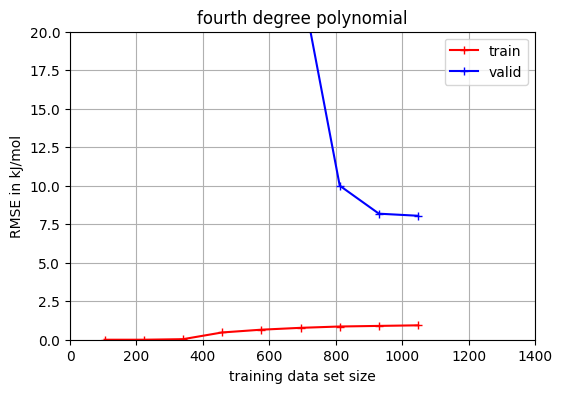

In [5]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

# Code selecting our model for which we want to obtain the learning curve. We choose a fourth degree polynomial.
num_pipeline = make_pipeline(PolynomialFeatures(degree=4, include_bias=True),StandardScaler())
cat_pipeline = make_pipeline(OneHotEncoder())

preprocessing = ColumnTransformer([("num",num_pipeline, make_column_selector(dtype_include=np.number)),
                                        ("cat",cat_pipeline, make_column_selector(dtype_include=object)),])

model_polyr = make_pipeline(preprocessing, LinearRegression())

# code of cross-validation
train_sizes, train_scores, valid_scores = learning_curve(
    model_polyr, X_train, y_train, cv=5,
    scoring="neg_root_mean_squared_error",train_sizes=np.linspace(0.1, 1.0, 9))

# code to make a nice plot
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", label="train")
plt.plot(train_sizes, valid_errors, "b-+", label="valid")
plt.legend(loc="upper right")
plt.xlabel("training data set size")
plt.ylabel("RMSE in kJ/mol")
plt.title("fourth degree polynomial")
plt.grid()
plt.axis([0, 1400, 0, 20])
plt.show()

The red line uses the training data to determine the root mean square error (RMSE). The blue line uses the validation set. Clearly visible is the large gab between both RMSE indicating overfitting. Let us compare it to the second and third degree polynomial. 

<center><img src="img/learning-curve-polynom.png" style="width: 1000px;"/></center>

Both lines converge quickly for the second degree polynomial. The same behavior is visible for the third degree polynomial starting from about 800 data points for the training data set size. Thus, we can expect that increasing the data set will not improve both models. Furthermore, the second degree polynomial is underfitted compared to the third degree polynomial. 